## imports
Add new imports here

In [163]:
import pandas as pd 
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from numpy import polyfit


# Functions for resampling and normalizing the data


In [ ]:
def normalize_dates(ijsselmeer, identifyer, column_name):
    # select data
    hardheid_ijsselmeer = ijsselmeer.loc[ijsselmeer[identifyer] == column_name]
    print("shape of found data", hardheid_ijsselmeer.shape)

    # make date column
    hardheid_ijsselmeer['date'] = pd.to_datetime(hardheid_ijsselmeer['Monsterdatum'], format='%d-%m-%Y')

    # set index to date column as well
    hardheid_ijsselmeer.set_index(hardheid_ijsselmeer['date'], inplace=True)

    # convert commas to decimal points
    hardheid_ijsselmeer['Waarde'] = hardheid_ijsselmeer['Waarde'].str.replace(',', '.')

    # make row numeric
    hardheid_ijsselmeer['Waarde'] =  pd.to_numeric(hardheid_ijsselmeer['Waarde'])

    # split the data in groups by year.
    DFList = []
    for group in hardheid_ijsselmeer.groupby(hardheid_ijsselmeer.index.year):
        DFList.append(group[1])

    # sort the dates and normalize to the same year (2010)
    for i, DF in enumerate(DFList):
        DFList[i].sort_index(inplace=True)
        DFList[i]['date'] = DFList[i]['date'].apply(lambda x: x - pd.DateOffset(years=i))

    # create array for holding the final data
    numpydata = np.zeros((52,len(DFList)),dtype=np.float32)

    # loop through dataframes, resample and interpolate the missing values (only a few in data)
    for i in range(len(DFList)):
        x = DFList[i]['Waarde']
        x.index = DFList[i]['date']
    
        res = x.resample("W").max()
        for j in range(52):
            try:    
                numpydata[j, i] = res[j]
            except:
                numpydata[j, i] = numpydata[j-1, i]
            
        a = numpydata[:,i].copy()

        nans, b = nan_helper(a)
        a[nans] = np.interp(b(nans), b(~nans), a[~nans])
        numpydata[:,i] = a

    return numpydata

def normalize_dates_fyto(ijsselmeer, identifyer, column_name):
    # select data
    hardheid_ijsselmeer = ijsselmeer.loc[ijsselmeer[identifyer] == column_name]
    print("shape of found data", hardheid_ijsselmeer.shape)

    # make date column
    hardheid_ijsselmeer['date'] = pd.to_datetime(hardheid_ijsselmeer['Monsterdatum'], format='%d-%m-%Y')

    # set index to date column as well
    hardheid_ijsselmeer.set_index(hardheid_ijsselmeer['date'], inplace=True)

    # convert commas to decimal points
    hardheid_ijsselmeer['Waarde'] = hardheid_ijsselmeer['Waarde'].str.replace(',', '.')

    # make row numeric
    hardheid_ijsselmeer['Waarde'] =  pd.to_numeric(hardheid_ijsselmeer['Waarde'])

    # split the data in groups by year.
    DFList = []
    for group in hardheid_ijsselmeer.groupby(hardheid_ijsselmeer.index.year):
        DFList.append(group[1])

    # sort the dates and normalize to the same year (2010)
    for i, DF in enumerate(DFList):
        DFList[i].sort_index(inplace=True)
        DFList[i]['date'] = DFList[i]['date'].apply(lambda x: x - pd.DateOffset(years=i))

    # create array for holding the final data
    numpydata = np.zeros((52,len(DFList)),dtype=np.float32)

    # loop through dataframes, resample and interpolate the missing values (only a few in data)
    for i in range(len(DFList)):
        x = DFList[i]['Waarde']
        x.index = DFList[i]['date']
    
        res = x.resample("W").max()
        for j in range(52):
            try:    
                numpydata[j, i] = res[j]
            except:
                numpydata[j, i] = numpydata[j-1, i]
            
        a = numpydata[:,i].copy()

        nans, b = nan_helper(a)
        a[nans] = np.interp(b(nans), b(~nans), a[~nans])
        numpydata[:,i] = a

    return numpydata

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def total_chl_fluo(andijk_post_bekken):
    # select data
    post_bekken_fluo = andijk_post_bekken.loc[andijk_post_bekken['Analyse'] == "CHL-FLUO"]
    print("shape of found data CHL-FLUO:", post_bekken_fluo.shape)

    # make date column
    post_bekken_fluo['date'] = pd.to_datetime(post_bekken_fluo['Monsterdatum'], format='%d-%m-%Y')

    # set index to date column as well
    post_bekken_fluo.set_index(post_bekken_fluo['date'], inplace=True)

    # convert commas to decimal points
    post_bekken_fluo['Waarde'] = post_bekken_fluo['Waarde'].str.replace(',', '.')

    # make row numeric
    post_bekken_fluo['Waarde'] =  pd.to_numeric(post_bekken_fluo['Waarde'])

    df_new = post_bekken_fluo[['Waarde', 'date']]

    df_new.groupby('date').agg('sum')
    post_bekken_fluo = df_new.groupby('date').agg('sum')
    post_bekken_fluo['date'] = post_bekken_fluo.index
    # print(post_bekken_fluo)

    # split the data in groups by year.
    DFList = []
    for group in post_bekken_fluo.groupby(post_bekken_fluo.index.year):
        DFList.append(group[1])

    # sort the dates and normalize to the same year (2010)
    for i, DF in enumerate(DFList):
        DFList[i].sort_index(inplace=True)
        DFList[i]['date'] = DFList[i]['date'].apply(lambda x: x - pd.DateOffset(years=i))


    # create array for holding the final data
    numpydata = np.zeros((52,len(DFList)),dtype=np.float32)

    # loop through dataframes, resample and interpolate the missing values (only a few in data)
    for i in range(len(DFList)):
        x = DFList[i]['Waarde']
        x.index = DFList[i]['date']

        res = x.resample("W").max()
        for j in range(52):
            try:    
                numpydata[j, i] = res[j]
            except:
                numpydata[j, i] = numpydata[j-1, i]

        a = numpydata[:,i].copy()

        nans, b = nan_helper(a)
        a[nans] = np.interp(b(nans), b(~nans), a[~nans])
        numpydata[:,i] = a
    return numpydata

# Load data 
Load data and format/save it to various dictionaries based on data source

In [164]:
ijsselmeer = pd.read_csv('csv/IJsselmeer_2010-2019.csv', encoding='unicode_escape', sep=';', keep_default_na=False)

andijk_inlaat = pd.read_csv('csv/Inlaat_pompstation_Andijk_2010-2019.csv', encoding='unicode_escape', sep=';', keep_default_na=False)

andijk_post_bekken = pd.read_csv('csv/Na_bekken_Andijk_2010-2019.csv', encoding='unicode_escape', sep=';', keep_default_na=False)

weekn = np.arange(52) 
weekn = np.stack((weekn,weekn,weekn,weekn,weekn,weekn,weekn,weekn)).T

# aangewezen waarden
calcium_ijssel = normalize_dates(ijsselmeer, "Component", "Calcium")
magnesium_ijssel = normalize_dates(ijsselmeer, "Component", "Magnesium")
temperatuur_ijssel = normalize_dates(ijsselmeer, "Analyse", "TEMP")
hardheid_totaal_ijssel = normalize_dates(ijsselmeer, "Analyse", "HH-TOT-BER")
waterstofcarbonaat_ijssel = normalize_dates(ijsselmeer, "Analyse", "HCO3")
koolstofdioxide_ijssel = normalize_dates(ijsselmeer, "Analyse", "CO2-BER")
zuurstof_opgelost_ijssel = normalize_dates(ijsselmeer, "Analyse", "O2")
zuurstof_verzadiging_ijssel = normalize_dates(ijsselmeer, "Analyse", "O2-VERZ")
totaal_org_ijssel = normalize_dates(ijsselmeer, "Analyse", "TOC")
natrium_ijssel = normalize_dates(ijsselmeer, "Component", "Natrium")

fyto_totaal_ijssel = normalize_dates(ijsselmeer, "Component", "Fytoplankton, totaal")
dummy_ijssel = np.zeros(calcium_ijssel.shape)

ijssel_d = {'calcium': calcium_ijssel, 'magnesium': magnesium_ijssel, 'temperatuur': temperatuur_ijssel, 'hardheid_totaal': hardheid_totaal_ijssel,
            'waterstofcarbonaat': waterstofcarbonaat_ijssel, 'koolstofdioxide': koolstofdioxide_ijssel, 'zuurstof_opgelost': zuurstof_opgelost_ijssel,
            'zuurstof_verzadiging':zuurstof_verzadiging_ijssel, 'totaal_org': totaal_org_ijssel, 'natrium': natrium_ijssel, 'weekn':weekn, 'fyto_totaal': fyto_totaal_ijssel}


calcium_post = normalize_dates(andijk_post_bekken, "Component", "Calcium")
magnesium_post = normalize_dates(andijk_post_bekken, "Component", "Magnesium")
temperatuur_post = normalize_dates(andijk_post_bekken, "Analyse", "TEMP")
hardheid_totaal_post = normalize_dates(andijk_post_bekken, "Analyse", "HH-TOT-BER")
waterstofcarbonaat_post = normalize_dates(andijk_post_bekken, "Analyse", "HCO3")
koolstofdioxide_post = normalize_dates(andijk_post_bekken, "Analyse", "CO2-BER")
# print(koolstofdioxide_post.shape)
# zuurstof_opgelost_post = normalize_dates(andijk_post_bekken, "Analyse", "O2")
# print(zuurstof_opgelost_post.shape)
# werkt niet for some reason
# zuurstof_verzadiging_post = normalize_dates(andijk_post_bekken, "Analyse", "O2-VERZ")

# print(zuurstof_verzadiging_post)
# totaal_org_post = normalize_dates(andijk_post_bekken, "Analyse", "TOC")
natrium_post = normalize_dates(andijk_post_bekken, "Component", "Natrium")
fyto_totaal_post = total_chl_fluo(andijk_post_bekken)
# dummy_post = np.zeros(calcium_post.shape)

natrium_delta = np.abs(natrium_ijssel - natrium_post)

post_d = {'calcium': calcium_post, 'magnesium': magnesium_post, 'temperatuur': temperatuur_post, 'hardheid_totaal': hardheid_totaal_post,'waterstofcarbonaat': waterstofcarbonaat_post, 'koolstofdioxide': koolstofdioxide_post, 'natrium': natrium_post, 'natrium_post':natrium_delta, 'weekn':weekn, 'fyto_totaal': fyto_totaal_post}

calcium_inlaat = normalize_dates(andijk_inlaat, "Component", "Calcium")
magnesium_inlaat = normalize_dates(andijk_inlaat, "Component", "Magnesium")
temperatuur_inlaat = normalize_dates(andijk_inlaat, "Analyse", "TEMP")
hardheid_totaal_inlaat = normalize_dates(andijk_inlaat, "Analyse", "HH-TOT-BER")
waterstofcarbonaat_inlaat = normalize_dates(andijk_inlaat, "Analyse", "HCO3")
koolstofdioxide_inlaat = normalize_dates(andijk_inlaat, "Analyse", "CO2-BER")
zuurstof_opgelost_inlaat = normalize_dates(andijk_inlaat, "Analyse", "O2")
zuurstof_verzadiging_inlaat = normalize_dates(andijk_inlaat, "Analyse", "O2-VERZ")
totaal_org_inlaat = normalize_dates(andijk_inlaat, "Analyse", "TOC")
natrium_inlaat = normalize_dates(andijk_inlaat, "Component", "Natrium")

# niet genoeg data
# fyto_totaal_inlaat = normalize_dates(andijk_inlaat, "Component", "Fytoplankton, totaal")
dummy_inlaat = np.zeros(calcium_inlaat.shape)

inlaat_d = {'calcium': calcium_inlaat, 'magnesium': magnesium_inlaat, 'temperatuur': temperatuur_inlaat, 'hardheid_totaal': hardheid_totaal_inlaat,
            'waterstofcarbonaat': waterstofcarbonaat_inlaat, 'koolstofdioxide': koolstofdioxide_inlaat, 'zuurstof_opgelost': zuurstof_opgelost_inlaat,
            'zuurstof_verzadiging':zuurstof_verzadiging_inlaat, 'totaal_org': totaal_org_inlaat, 'natrium': natrium_inlaat, 'weekn':weekn}


# ijssel_d['natrium_post'] = natrium_post

# make dict containing all data, add region name to key
total_d = {}
for key, value in ijssel_d.items():
    total_d[key + "_ijssel"] = value
    print(total_d[key + "_ijssel"].shape)
    total_d[key + "_ijssel"][:,:8]
    
for key, value in post_d.items():
    total_d[key + "_post"] = value

for key, value in inlaat_d.items():
    total_d[key + "_inlaat"] = value

natrium_delta = np.abs(natrium_ijssel - natrium_post)

total_d['natrium_delta'] = natrium_delta

print("done!")

/home/jonathan/anaconda3/envs/datascience/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


shape of found data (485, 11)


/home/jonathan/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/home/jonathan/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/jonathan/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

shape of found data (487, 11)
shape of found data (478, 11)
shape of found data (484, 11)
shape of found data (478, 11)
shape of found data (476, 11)
shape of found data (142, 11)
shape of found data (122, 11)
shape of found data (124, 11)
shape of found data (308, 11)
shape of found data (114, 11)
shape of found data (499, 11)
shape of found data (499, 11)
shape of found data (492, 11)
shape of found data (499, 11)
shape of found data (498, 11)
shape of found data (489, 11)
shape of found data (498, 11)
shape of found data CHL-FLUO: (2420, 11)


/home/jonathan/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:20: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/home/jonathan/anaconda3/envs/datascience/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


shape of found data (484, 11)
shape of found data (484, 11)
shape of found data (485, 11)
shape of found data (484, 11)
shape of found data (484, 11)
shape of found data (481, 11)
shape of found data (519, 11)
shape of found data (481, 11)
shape of found data (161, 11)
shape of found data (192, 11)
(52, 10)
(52, 10)
(52, 10)
(52, 10)
(52, 10)
(52, 10)
(52, 10)
(52, 10)
(52, 10)
(52, 10)
(52, 8)
(52, 10)
done!


In [167]:
# remove year with missing data

for key, value in ijssel_d.items():
    total_d[key + "_ijssel"] = value
    total_d[key + "_ijssel"] = total_d[key + "_ijssel"][:,:9]
#     print(total_d[key + "_ijssel"].shape)
    
for key, value in post_d.items():
    total_d[key + "_post"] = value
    total_d[key + "_post"] = total_d[key + "_post"][:,:9]

for key, value in inlaat_d.items():
    total_d[key + "_inlaat"] = value
    total_d[key + "_inlaat"] = total_d[key + "_inlaat"][:,:9]
    
print("Done!")

Done!


In [168]:
# test cell

# Seasonality Removal
Some of the time series have seasonal components, performance of models is in general better on data that is stationary (no seasonal component). So I model the seasonality and remove it from the data for all seasonal time series.

## Example of seasonality in data

Coefficients: [-1.23442374e-04  1.71433664e-02 -6.97107974e-01  7.73450926e+00
  1.59705526e+02]


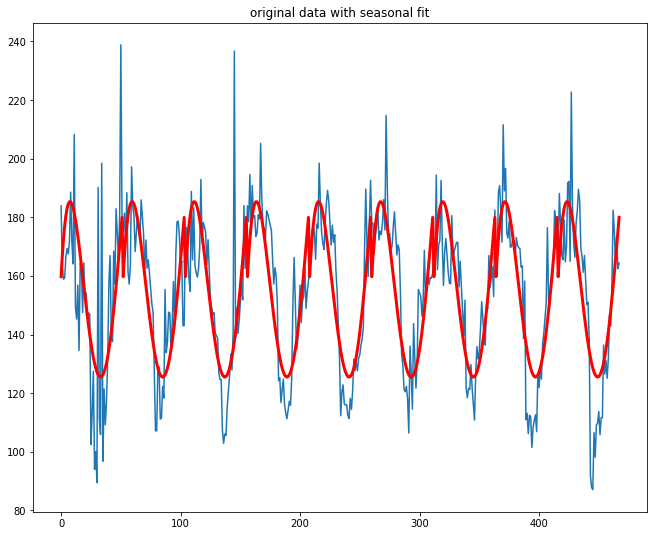

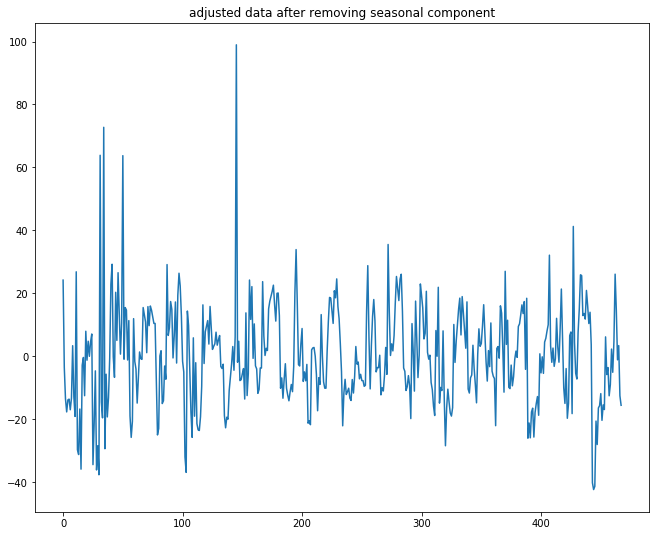

In [169]:
seasonal_vars = [
    'hardheid_totaal',
    'temperatuur',
    'calcium',
    'magnesium',
    'waterstofcarbonaat',
    'koolstofdioxide',
    'zuurstof_opgelost',
    'zuurstof_verzadiging',
]
non_seasonal_vars = [
    'totaal_org',
    'natrium'
]
# ALL VARIABLES:
# calcium_ijssel
# magnesium_ijssel
# temperatuur_ijssel
# hardheid_totaal_ijssel
# waterstofcarbonaat_ijssel
# koolstofdioxide_ijssel
# zuurstof_opgelost_ijssel
# zuurstof_verzadiging_ijssel
# totaal_org_ijssel
# natrium_ijssel

series = pd.Series(total_d['waterstofcarbonaat_ijssel'].flatten(order='F'))

# fit polynomial: x^2*b1 + x*b2 + ... + bn
X = [i%52 for i in range(0, len(series))]
y = series.values
degree = 4
coef = polyfit(X, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(X)):
    value = coef[-1]
    for d in range(degree):
        value += X[i]**(degree-d) * coef[d]
    curve.append(value)
    
# plot curve over original data
f, ax = plt.subplots(figsize=(11, 9))
plt.title("original data with seasonal fit")
sns.lineplot(data=series.values)
sns.lineplot(data=pd.Series(curve), color='red', linewidth=3)


values = series.values
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
    
f, ax = plt.subplots(figsize=(11, 9))
plt.title("adjusted data after removing seasonal component")
sns.lineplot(data=pd.Series(diff))
# pyplot.plot(diff)
plt.show()

# Removing Seasonality from data

In [170]:
regions = ['ijssel', 'post', 'inlaat']
stationary_d = {}
for var in seasonal_vars:
    for region in regions:
        if '{}_{}'.format(var, region) in total_d:
            series = pd.Series(total_d['{}_{}'.format(var, region)].flatten(order='F'))

            # fit polynomial: x^2*b1 + x*b2 + ... + bn
            X = [i%52 for i in range(0, len(series))]
            y = series.values
            degree = 4
            coef = polyfit(X, y, degree)
            
            # print('Coefficients: %s' % coef)
            # create curve
            curve = list()
            for i in range(len(X)):
                value = coef[-1]
                for d in range(degree):
                    value += X[i]**(degree-d) * coef[d]
                curve.append(value)

            values = series.values
            diff = list()
            for i in range(len(values)):
                value = values[i] - curve[i]
                diff.append(value)

            stationary_d['{}_{}'.format(var, region)] = np.array(diff).reshape(52,9)

            
for var in non_seasonal_vars:
    for region in regions:
        if '{}_{}'.format(var, region) in total_d:
            stationary_d['{}_{}'.format(var, region)] = total_d['{}_{}'.format(var, region)]

stationary_d['natrium_delta'] = total_d['natrium_delta'][:,:9]
stationary_d['weekn'] = weekn[:,:9] # weeknumbers for debugging purposes
print("Done!")
print("n_features: {}".format(len(stationary_d)))

Done!
n_features: 29


# Make train-test blocks for regression models
Stack the data in various splits for use with machine learning algorithms 

In [171]:
years = 7 # starting from year 0 (2010)
# vars_to_use = ['calcium', 'magnesium', 'hardheid_totaal', 'waterstofcarbonaat', 'koolstofdioxide', 'zuurstof_opgelost', 'zuurstof_verzadiging', 'totaal_org', 'natrium', 'weekn', 'fyto_totaal']
# vars_to_use = ['zuurstof_opgelost', 'calcium', 'zuurstof_verzadiging', 'waterstofcarbonaat', 'koolstofdioxide']
source_df = stationary_d
vars_to_use = list(source_df.keys())
# vars_to_use.remove('weekn')
# vars_to_use = ['calcium', 'magnesium', 'hardheid_totaal']
target_var = "hardheid_totaal_ijssel"
# vars_to_use.remove(target_var)
# vars_to_use.remove('calcium_ijssel')
# vars_to_use.remove('waterstofcarbonaat_ijssel')
target_year = 3 # takes year at index 8 :P

if len(vars_to_use) < 2:
    vars_to_use.append('dummy')

# block to prepare input data 
x_train_part = source_df[vars_to_use[0]][:,0]
for var in vars_to_use[1:]:
    x_train_part = np.vstack((x_train_part, source_df[var][:,0]))

x_train = x_train_part.T

for i in range(1,years):
    x_train_part = source_df[vars_to_use[0]][:,i]
    
    for var in vars_to_use[1:]:
#         print(var)
#         print(source_df[var])
        x_train_part = np.vstack((x_train_part, source_df[var][:,i]))
    
    x_train_part = x_train_part.T
    x_train = np.vstack((x_train, x_train_part))

y_train = source_df[target_var][:,0]
for i in range(1, years):
    y_train_part = source_df[target_var][:,i]
    y_train = np.hstack((y_train, y_train_part))

y_train = y_train.T
    
x_test = source_df[vars_to_use[0]][:,target_year]
for var in vars_to_use[1:]:
    x_test = np.vstack((x_test, source_df[var][:,target_year]))

x_test = x_test.T
y_test  = source_df[target_var][:,target_year]
    
# print(x_train)
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(364, 29)
(364,)
(52, 29)
(52,)


# Predictions
Estimate target values using combinations of other values

0.9997911984262602
feature: hardheid_totaal_ijssel, importance: 0.899327
feature: hardheid_totaal_post, importance: 0.000051
feature: hardheid_totaal_inlaat, importance: 0.000976
feature: temperatuur_ijssel, importance: 0.000127
feature: temperatuur_post, importance: 0.000393
feature: temperatuur_inlaat, importance: 0.000199
feature: calcium_ijssel, importance: 0.042069
feature: calcium_post, importance: 0.000027
feature: calcium_inlaat, importance: 0.000658
feature: magnesium_ijssel, importance: 0.000811
feature: magnesium_post, importance: 0.000202
feature: magnesium_inlaat, importance: 0.000184
feature: waterstofcarbonaat_ijssel, importance: 0.047386
feature: waterstofcarbonaat_post, importance: 0.000671
feature: waterstofcarbonaat_inlaat, importance: 0.000073
feature: koolstofdioxide_ijssel, importance: 0.001053
feature: koolstofdioxide_post, importance: 0.000029
feature: koolstofdioxide_inlaat, importance: 0.000542
feature: zuurstof_opgelost_ijssel, importance: 0.000099
feature: z

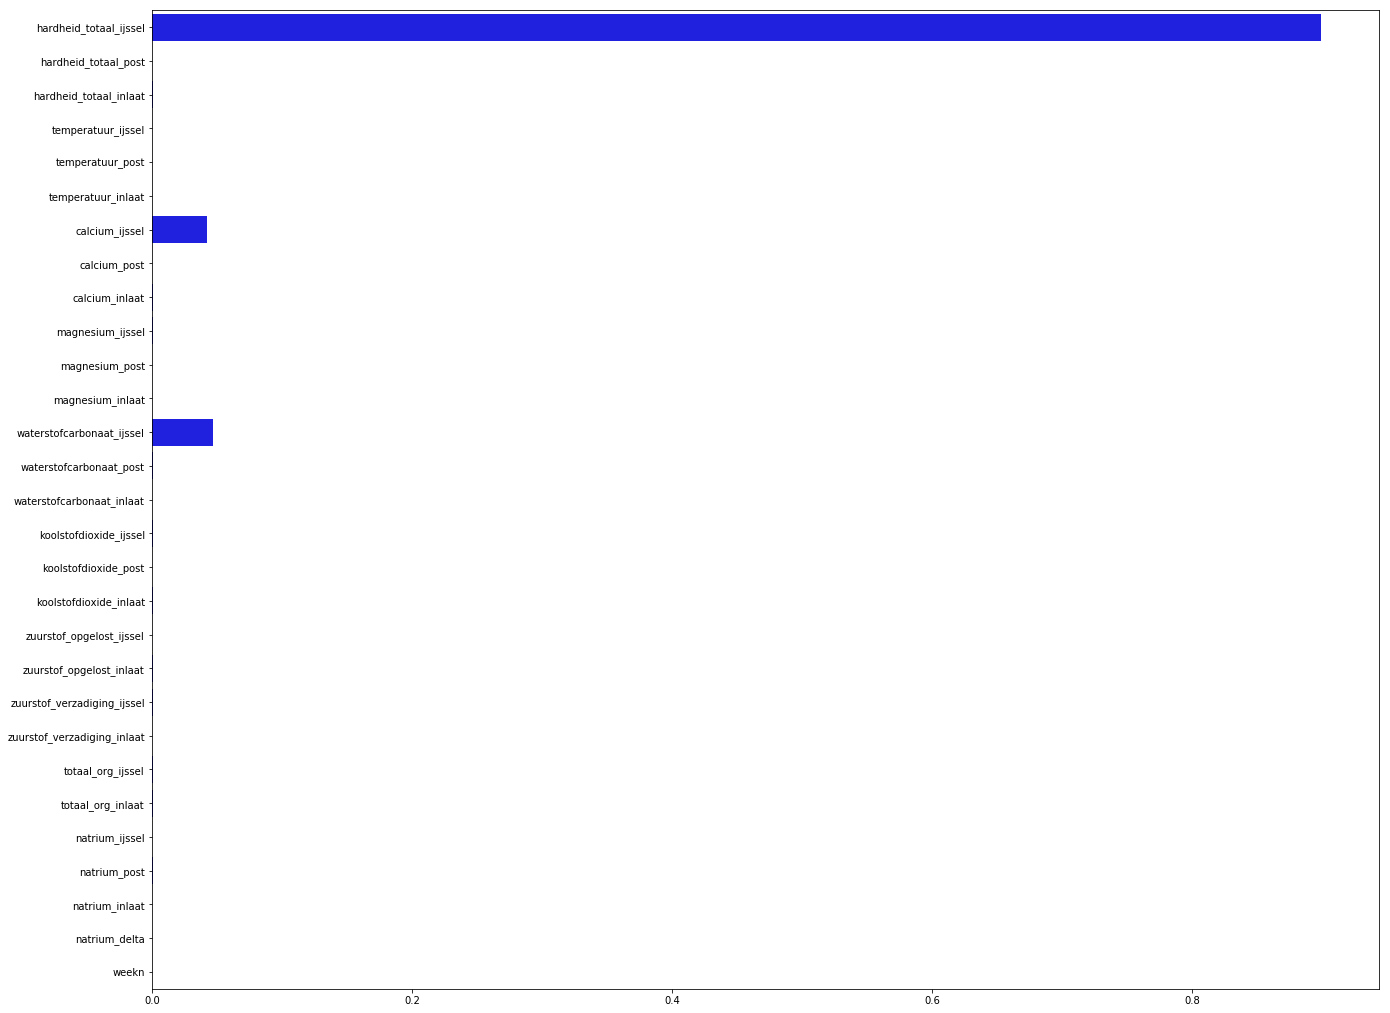

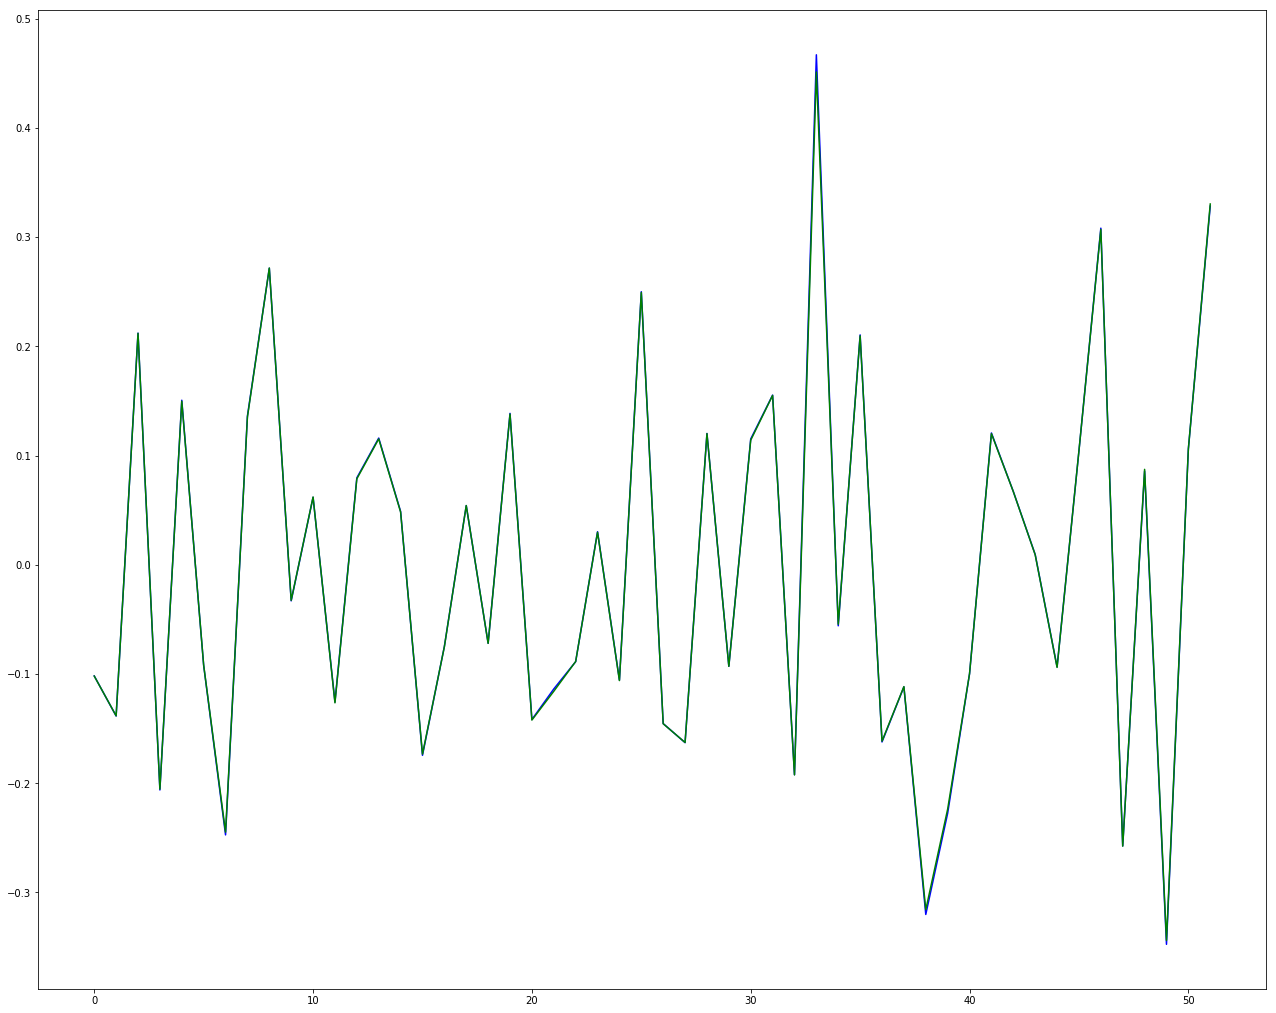

In [172]:
# rfr = XGBRegressor()
# rfr = KNeighborsRegressor(n_neighbors=1)
rfr = RandomForestRegressor(n_estimators=100, criterion='mse')
# rfr = LinearRegression()
# rfr = SVR(gamma='auto', kernel='poly')
# rfr = BaggingRegressor()
# rfr = DummyRegressor()

tmpshuffle = np.hstack((x_train, y_train[:,np.newaxis]))
# print(tmpshuffle)

np.random.shuffle(tmpshuffle)

x_train = tmpshuffle[:,:-1]
y_train = tmpshuffle[:,-1]


rfr.fit(x_train, y_train)

preds_rfr_ens = rfr.predict(x_test)
print(rfr.score(x_test, y_test))
importance_dict = {}
try:
    _ = rfr.feature_importances_
    for i, name in enumerate(vars_to_use):
        imp =  rfr.feature_importances_[i]
        importance_dict[name] = imp
        print("feature: {}, importance: {:3f}".format(name, imp))
    
    f, ax = plt.subplots(figsize=(22, 18))
    # plt.title('feature importances fyto_totaal post')
    ax = sns.barplot(y=list(importance_dict.keys()), x=list(importance_dict.values()), color='b')
    # ax.set(xscale="log")
except:
    print("no feature importances")
    
print("target value: {}".format(target_var))

scaler = MinMaxScaler()
# preds_rfr_ens = scaler.fit_transform(preds_rfr_ens.reshape(-1, 1))
# y_test = scaler.fit_transform(y_test.reshape(-1, 1))

# verification = source_df['fyto_totaal_post'][:,target_year].copy()
# verification = scaler.fit_transform(verification.reshape(-1, 1))
# verification = np.squeeze(verification)
# y_test = np.squeeze(y_test)
# preds_rfr_ens = np.squeeze(preds_rfr_ens)


f, ax = plt.subplots(figsize=(22, 18))
sns.lineplot(data=preds_rfr_ens, color='blue')
sns.lineplot(data=y_test, color='green')
# plt.title('feature importances fyto_totaal post')
# ax = sns.barplot(y=list(importance_dict.keys()), x=list(importance_dict.values()), color='b')
# ax.set(xscale="log")

# print(post_d['fyto_totaal'][:,0])

# f, ax = plt.subplots(figsize=(22, 18))


# sns.title("all years of zuurstof opgelost")
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,0], color='blue')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,1], color='green')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,2], color='orange')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,3], color='red')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,4], color='black')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,5], color='grey')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,6], color='purple')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,7], color='yellow')
# sns.lineplot(data=ijssel_d['zuurstof_opgelost'][:,8], color='teal')
# sns.lineplot(data=post_d['calcium'][:ijssel_d['zuurstof_opgelost'],6], color='purple')

# sns.lineplot(data=verification, color='orange')
# print(y_test.shape)
# print(verification.shape)

# sns.lineplot(data=source_df['dummy'][:,target_year], color='green')
# sns.lineplot(data=source_df['koolstofdioxide'][:,target_year], color='blue')
# sns.lineplot(data=source_df['dummy'][:,target_year], color='blue')
# sns.lineplot(data=natrium_delta[:,1], color='green')
# sns.lineplot(data=hardheid_totaal[:,1], color='green')

# Covariance estimations
Code for testing out the covariance between the different features

(364, 29)


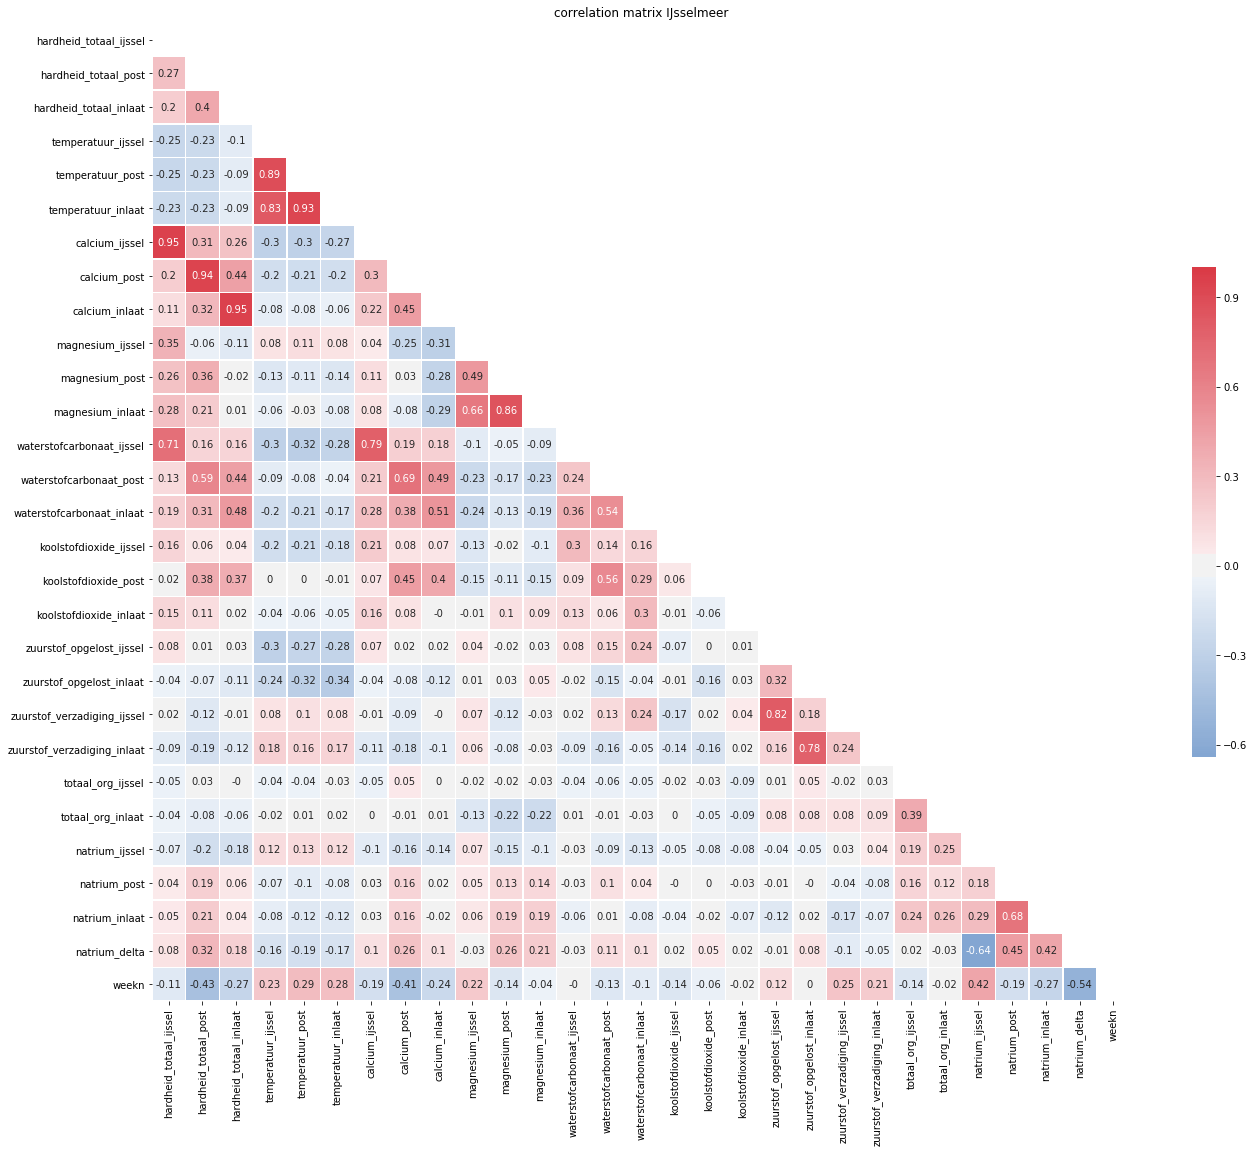

In [173]:
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import MinCovDet
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
print(x_train.shape)
transformed_x = scaler.fit_transform(x_train)

# cov = EmpiricalCovariance().fit(x_train)
# print(np.round(cov.covariance_, 2))
cov = EmpiricalCovariance().fit(transformed_x)
corr = pd.DataFrame(cov.covariance_, columns=vars_to_use, index=vars_to_use)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(22, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)
# print(corr)
corr = np.round(corr, 2)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('correlation matrix IJsselmeer')
plt.show()

# Old code
Ignore code below

In [401]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
# rfr = RandomForestRegressor()
# rfr.fit(x, y) 


In [ ]:
rfr = RandomForestRegressor(n_estimators=100, criterion='mse')
# rfr = KNeighborsRegressor()

x_train1 = np.stack((natrium_delta[:,0], temperatuur[:,0], zuurstof_verzadiging[:,0], mangaan[:,0], magnesium[:,0], carbonaat[:,0], natrium[:,0], koolstofdioxide[:,0], zuurstof_opgelost[:,0], weekn)).T
x_train2 = np.stack((natrium_delta[:,1], temperatuur[:,1], zuurstof_verzadiging[:,1], mangaan[:,1], magnesium[:,1], carbonaat[:,1], natrium[:,1], koolstofdioxide[:,1], zuurstof_opgelost[:,1], weekn)).T
x_train3 = np.stack((natrium_delta[:,2], temperatuur[:,2], zuurstof_verzadiging[:,2], mangaan[:,2], magnesium[:,2], carbonaat[:,2], natrium[:,2], koolstofdioxide[:,2], zuurstof_opgelost[:,2], weekn)).T
x_train = np.vstack((x_train1, x_train2, x_train3))

y_train1 = hardheid_totaal[:,0].T
y_train2 = hardheid_totaal[:,1].T
y_train3 = hardheid_totaal[:,2].T
y_train = np.hstack((y_train1, y_train2, y_train3))

year_n = 6
x_test = np.stack((natrium_delta[:,year_n], temperatuur[:,year_n], zuurstof_verzadiging[:,year_n], mangaan[:,year_n], magnesium[:,year_n], carbonaat[:,year_n], natrium[:,year_n], koolstofdioxide[:,year_n], zuurstof_opgelost[:,year_n], weekn)).T
y_test = hardheid_totaal[:,year_n].T

rfr.fit(x_train, y_train)
preds_rfr_ens = rfr.predict(x_test)
print(rfr.score(x_test, y_test))
feature_names = ["natrium_delta","temp", "zuurstof_verzadiging", "mangaan", "magnesium", "carbonaat", "natrium", "koolstofdioxide", "zuurstof_opgelost", "weekn"]
for i, name in enumerate(feature_names):
    imp =  rfr.feature_importances_[i]
    print("feature: {}, importance: {:3f}".format(name, imp))


# sns.lineplot(data=preds_rfr_ens, color='orange')
# sns.lineplot(data=y_test, color='green')
sns.lineplot(data=natrium_delta[:,1], color='green')
# sns.lineplot(data=hardheid_totaal[:,1], color='green')

0.23232718451867362
feature: natrium_delta, importance: 0.135794
feature: temp, importance: 0.193308
feature: zuurstof_verzadiging, importance: 0.101219
feature: mangaan, importance: 0.030814
feature: magnesium, importance: 0.094365
feature: carbonaat, importance: 0.001201
feature: natrium, importance: 0.060915
feature: koolstofdioxide, importance: 0.078872
feature: zuurstof_opgelost, importance: 0.130276
feature: weekn, importance: 0.173237


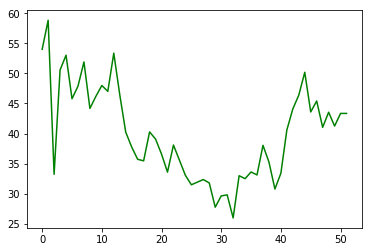

In [480]:

rfr = RandomForestRegressor(n_estimators=100, criterion='mse')
# rfr = KNeighborsRegressor()

x_train1 = np.stack((natrium_delta[:,0], temperatuur[:,0], zuurstof_verzadiging[:,0], mangaan[:,0], magnesium[:,0], carbonaat[:,0], natrium[:,0], koolstofdioxide[:,0], zuurstof_opgelost[:,0], weekn)).T
x_train2 = np.stack((natrium_delta[:,1], temperatuur[:,1], zuurstof_verzadiging[:,1], mangaan[:,1], magnesium[:,1], carbonaat[:,1], natrium[:,1], koolstofdioxide[:,1], zuurstof_opgelost[:,1], weekn)).T
x_train3 = np.stack((natrium_delta[:,2], temperatuur[:,2], zuurstof_verzadiging[:,2], mangaan[:,2], magnesium[:,2], carbonaat[:,2], natrium[:,2], koolstofdioxide[:,2], zuurstof_opgelost[:,2], weekn)).T
x_train = np.vstack((x_train1, x_train2, x_train3))

y_train1 = hardheid_totaal[:,0].T
y_train2 = hardheid_totaal[:,1].T
y_train3 = hardheid_totaal[:,2].T
y_train = np.hstack((y_train1, y_train2, y_train3))

year_n = 6
x_test = np.stack((natrium_delta[:,year_n], temperatuur[:,year_n], zuurstof_verzadiging[:,year_n], mangaan[:,year_n], magnesium[:,year_n], carbonaat[:,year_n], natrium[:,year_n], koolstofdioxide[:,year_n], zuurstof_opgelost[:,year_n], weekn)).T
y_test = hardheid_totaal[:,year_n].T

rfr.fit(x_train, y_train)
preds_rfr_ens = rfr.predict(x_test)
print(rfr.score(x_test, y_test))
feature_names = ["natrium_delta","temp", "zuurstof_verzadiging", "mangaan", "magnesium", "carbonaat", "natrium", "koolstofdioxide", "zuurstof_opgelost", "weekn"]
for i, name in enumerate(feature_names):
    imp =  rfr.feature_importances_[i]
    print("feature: {}, importance: {:3f}".format(name, imp))


# sns.lineplot(data=preds_rfr_ens, color='orange')
# sns.lineplot(data=y_test, color='green')
sns.lineplot(data=natrium_delta[:,1], color='green')
# sns.lineplot(data=hardheid_totaal[:,1], color='green')